### libraries

In [126]:
## Libraries ##
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import itertools
from sklearn.utils import shuffle
import sys

### NN class

In [127]:
## NN class
class dlnet:
    
    ## Defining the class attributes
    def __init__(self, x, y):
        # input layer
        self.X = x
        
        # desired output
        self.Y = y
        
        # network output
        self.Yh = np.zeros((1, self.Y.shape[1]))
        
        # number of layers
        self.L = 2
        
        # the number of nodes (neurons) in each layer
        # indices correspond to the nodes in each respective layer
        self.dims = [9, 15, 1]
        
        # dictionariy to hold W and b parameters of the network
        self.param = {}
        
        # cache for intermediary values
        self.ch = {}
        
        self.grad = {}
        # loss value of the network
        self.loss = []
        
        # learning rate        
        self.lr = 0.07
        
        # number of training samples
        self.sam = self.Y.shape[1]
        
        # confidence threshold
        self.threshold = 0.5
        
        
    ## NN class functions ##
        
        
    ## NN Parameter initialization function 
    def nInit(self):    
        np.random.seed(1)

        # number of rows is the number of hidden units of that layer 
        # and number of rows from previous layer
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 

        # same number of rows as W1 and a single column
        self.param['b1'] = np.zeros((self.dims[1], 1)) 

        # number rows is the number of hidden nodes in the current layer 
        # and the columns is the number of columns of the previous layer
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 

        # same number of rows as W2 and a single column
        self.param['b2'] = np.zeros((self.dims[2], 1))  

        return
    

    ## Forward pass functions
    
    # Forward Function
    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1

        Z2 = self.param['W2'].dot(A1) + self.param['b2']
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh = A2
        loss = self.nloss(A2)
        
        return self.Yh, loss

    
    ## Loss calculation function
    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss
    
    
    ## Back propogation functions
    
    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))        

        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 

        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  

        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
            
            
    ## Iteration Functions     
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         

        self.nInit()

        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()

            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        return
    
    
    ## Prediction Function
    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        mis_rate = 1 - np.sum((comp == y)/x.shape[1])

        print("Misclassification Rate: ", mis_rate)
        
        return mis_rate


## Utility Functions ##

# Sigmoid Function
def Sigmoid(Z):
    return 1/(1 + np.exp(-Z))

# Relu Function
def Relu(Z):
    return np.maximum(0,Z)

def dRelu(x):
    x[x<=0] = 0
    x[x>0]  = 1

    return x

def dSigmoid(Z):
    s = 1/(1 + np.exp(-Z))
    dZ = s * (1-s)
    return dZ

# starting point

## dataset description

- There are 699 rows in total, belonging to 699 patients

- The first column is an ID that identifies each patient.

- The following 9 columns are features that express different types of information connected to the detected tumors. They represent data related to: Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli and Mitoses.

- The last column is the class of the tumor and it has two possible values: 2 means that the tumor was found to be benign. 4 means that it was found to be malignant.

- We are told as well that there are a few rows that contain missing data. The missing data is represented in the data-set with the ? character.

- Out of the 699 patients in the dataset, the class distribution is: Benign: 458 (65.5%) and Malignant: 241 (34.5%)

In [128]:

## Data Preparation ##

# Read in the dataset
df = pd.read_csv('wisconsin-cancer-dataset.csv', header = None)

# Normalize the response variable to 0-1 scale
df.iloc[:, 10].replace(2, 0, inplace = True)
df.iloc[:, 10].replace(4, 1, inplace = True)

# Remove expl vars with unknown values
df = df[~df[6].isin(['?'])]

# Set DF type
df = df.astype(float)

# Apply min-max normalization
names = df.columns[0:10]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df.iloc[:, 0:10])
scaled_df = pd.DataFrame(scaled_df, columns = names)

# Split the data up into test and training
scaled_df = shuffle(scaled_df).reset_index()

# training data
x=scaled_df.iloc[0:500,1:10].values.transpose()
y=df.iloc[0:500,10:].values.transpose()

# test data
xval=scaled_df.iloc[501:683,1:10].values.transpose()
yval=df.iloc[501:683,10:].values.transpose()


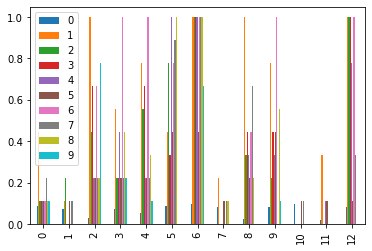

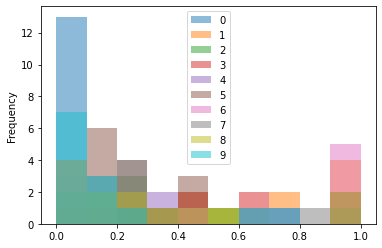

In [129]:
# some visualization of the features
scaled_df[10]= df[10]
scaled_df.iloc[0:13,1:11].plot.bar();
scaled_df.iloc[0:13,1:11].plot.hist(alpha=0.5)

In [134]:
## Training ##

# Create NN instance and train it
nn = dlnet(x, y)
nn.dims = [9, 10, 1]
nn.lr = float(0.07)

print("--> Training NN with dimensions (9, ", sys.argv[1], ", 1) and LR = ", sys.argv[2])

# 50000 iterations of back propogation
nn.gd(x, y, iter = 50000)

# Training misclassification rate
print("\n")
print("Training misclassification rate:")
pred_train = nn.pred(x, y)

# Test misclassification rate
print("Test misclassification rate:")
pred_test = nn.pred(xval, yval)

# print the training and test set predictions
nn.X = xval
nn.Y = yval

yvalh, loss = nn.forward()

print("\n")

print("Predicted training values:")
print("\ny",np.around(yval[:,0:50,], decimals=0).astype(np.int), "\n")       

print("Predicted test values:")
print("\nyh",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")

--> Training NN with dimensions (9,  -f , 1) and LR =  /Users/Kaveh/Library/Jupyter/runtime/kernel-0c3ebeeb-851b-4f90-be06-462f39014824.json
Cost after iteration 0: 0.692703
Cost after iteration 500: 0.667095
Cost after iteration 1000: 0.664586
Cost after iteration 1500: 0.661646
Cost after iteration 2000: 0.659157
Cost after iteration 2500: 0.656727
Cost after iteration 3000: 0.654844
Cost after iteration 3500: 0.653117
Cost after iteration 4000: 0.651382
Cost after iteration 4500: 0.649657
Cost after iteration 5000: 0.648049
Cost after iteration 5500: 0.646614
Cost after iteration 6000: 0.645187
Cost after iteration 6500: 0.643762
Cost after iteration 7000: 0.642416
Cost after iteration 7500: 0.641184
Cost after iteration 8000: 0.640013
Cost after iteration 8500: 0.638932
Cost after iteration 9000: 0.637893
Cost after iteration 9500: 0.636932
Cost after iteration 10000: 0.635992
Cost after iteration 10500: 0.634921
Cost after iteration 11000: 0.633894
Cost after iteration 11500: 0.63